# 0. Import Packages and Data

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib. pyplot as plt
import seaborn as sns

In [46]:
# Import data that was output in previous notebook "3. Preprocessing and Training"
df = pd.read_csv(r'/Users/chaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/df_emo_full_pat.csv', index_col = 0)

# Import Training and Testing data from previous notebook
X_train = pd.read_csv(r'/Users/chaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/X_train.csv', index_col = 0)
X_test = pd.read_csv(r'/Users/chaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/X_test.csv', index_col = 0)
y_train = pd.read_csv(r'/Users/chaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/y_train.csv', index_col = 0)
y_test = pd.read_csv(r'/Users/chaseweber/Desktop/Springboard/Billboard Top 10 Prediction/DataFiles/y_test.csv', index_col = 0)

### 0a. Check that data is imported correctly

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229526 entries, 202664 to 249342
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Instance                     229526 non-null  int64  
 1   Previous Week Position       229526 non-null  float64
 2   Weeks on Chart               229526 non-null  int64  
 3   wordCount                    229526 non-null  float64
 4   allWordCount                 229526 non-null  float64
 5   MTLD                         229526 non-null  float64
 6   TTR                          229526 non-null  float64
 7   CTTR                         229526 non-null  float64
 8   sentimentScore               229526 non-null  float64
 9   sentimentScore_pos           229526 non-null  float64
 10  sentimentScore_neg           229526 non-null  float64
 11  emoWordCount                 229526 non-null  float64
 12  emo_score                    229526 non-null  float64

In [49]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229526 entries, 202664 to 249342
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Week Position  229526 non-null  int64
dtypes: int64(1)
memory usage: 3.5 MB


# 1. Model Construction

Import modeling packages.

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import lightgbm

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics

## Light Gradient Boosting Machine

#### Run an initial LightGBM model.

In [63]:
start_time = datetime.now()
lgbm_default = LGBMRegressor()
lgbm_default.fit(X_train, y_train)
end_time = datetime.now()

print("Train Score: " + str(lgbm_default.score(X_train, y_train)))
print("Test Score: " + str(lgbm_default.score(X_test, y_test)))
print(end_time - start_time)

Train Score: 0.9092031142148768
Test Score: 0.9069257179534789
0:00:01.357044


#### Conduct a cross validated random search for number of leafs.

In [54]:
param_grid = {'num_leaves' : np.arange(15, 2000, 1), 'max_depth' : np.arange(2, 20,1), 'learning_rate' : np.arange(.75, 1.25, .01), 'n_estimators' : np.arange(75, 175, 1)}
start_time = datetime.now()
lgbm = LGBMRegressor()
lgbm_cv = RandomizedSearchCV(lgbm, param_grid, n_iter = 50, cv=5, random_state = 123)
lgbm_cv.fit(X_train, y_train)
end_time = datetime.now()

print("Best Score:" + str(lgbm_cv.best_score_))
print("Best Parameter: " + str(lgbm_cv.best_params_))
print(end_time - start_time)

Best Score:0.9015131575858437
Best Parameter: {'num_leaves': 1815, 'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.8200000000000001}
1:09:02.108894


From the random search: The best score is 0.9015 with 1815 leaves, 147 estimators, depth of 3, and .82 learning_rate. 1 hour 10 minutes to run.

#### Run a final Light Gradient Boosting Machine with 1815 leaves, 147 estimators, depth of 3, and .82 learning_rate. 

In [66]:
start_time = datetime.now()
lgbm_final = LGBMRegressor(num_leaves = 1815, n_estimators = 147, max_depth = 3, learning_rate = .82)
lgbm_final.fit(X_train, y_train)
end_time = datetime.now()

print("Train Score: " + str(lgbm_final.score(X_train, np.ravel(y_train))))
print("Test Score: " + str(lgbm_final.score(X_test, np.ravel(y_test))))

print("Model took " + str(end_time - start_time) + " time to run.")

Train Score: 0.9065653456419712
Test Score: 0.9044478579710841
Model took 0:00:00.542723 time to run.


#### Plot feature importances of our selected model

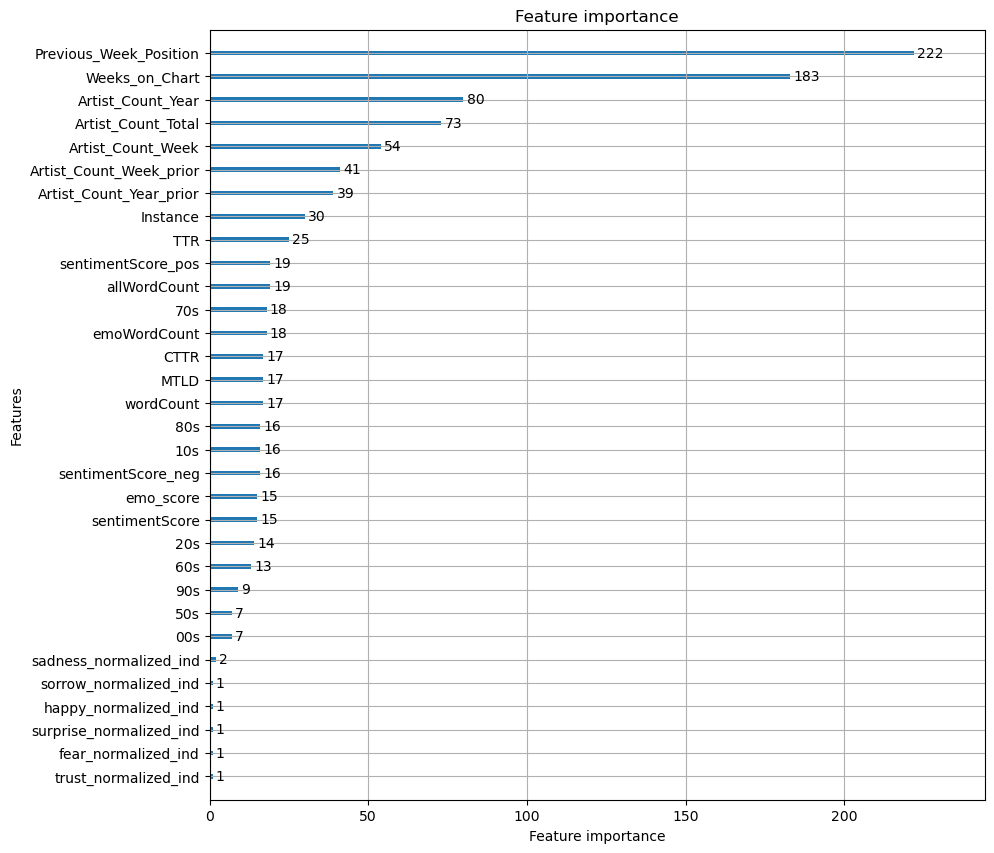

In [67]:
ax = lightgbm.plot_importance(lgbm_final, max_num_features=40, figsize=(10,10))
plt.show()

Our top features in our selected model are Previous Week Position, Weeks on Chart, Artist Count Year, Artist Count Total, and Artist Count Week.

#### Are feature importances in our default model different?

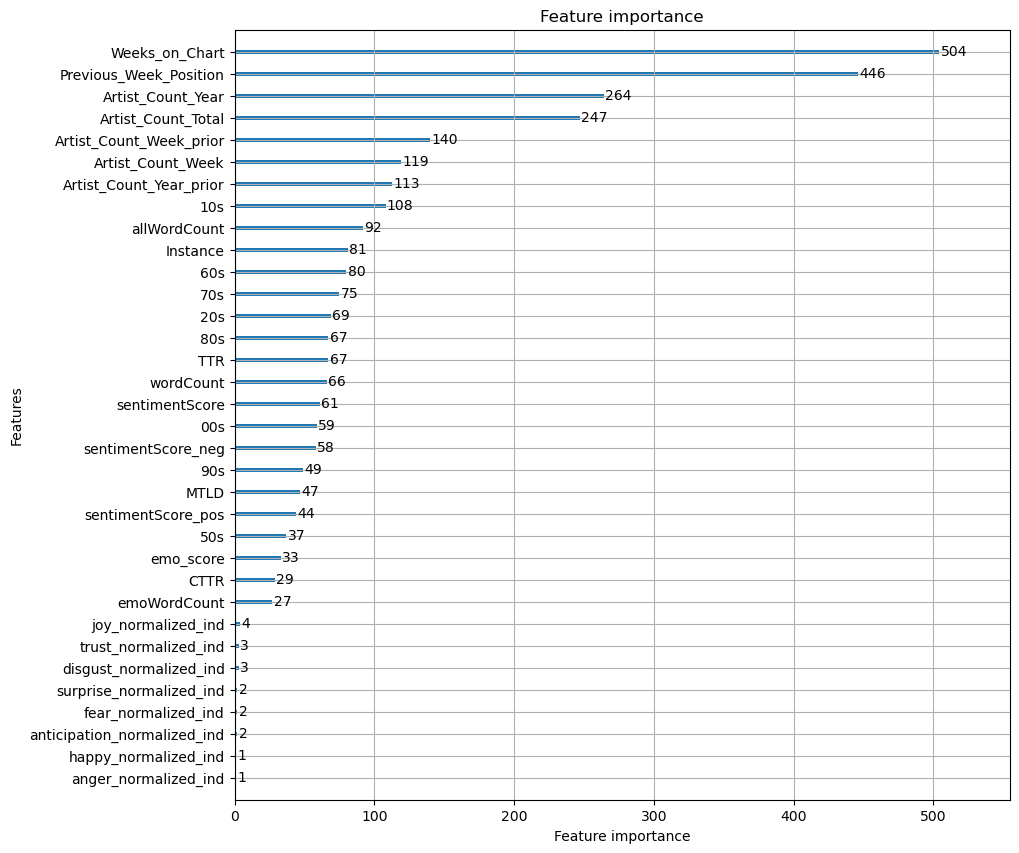

In [68]:
ax = lightgbm.plot_importance(lgbm_default, max_num_features=40, figsize=(10,10))
plt.show()

The default LGBM Model are Weeks on Chart, Previous Week Position, Artist Count Year, Artist Count Total, and Artist Count Week Prior.

#### Both default and tuned LGBM models show similar top features.

#### A lot of these factors are out of our control. Of the factors that can be controlled, word count and sentiment score appear to be predictive. 

## Random Forest

#### Run an initial model.

In [87]:
start_time = datetime.now()
rf_reg_default = RandomForestRegressor(n_estimators = 10, max_depth = 3)
rf_reg_default.fit(X_train, np.ravel(y_train))
end_time = datetime.now()

print("Train Score: " + str(rf_reg_default.score(X_train, np.ravel(y_train))))
print("Test Score: " + str(rf_reg_default.score(X_test, np.ravel(y_test))))
print("Model took " + str(end_time - start_time) + " time to run.")

Train Score: 0.8403117275479763
Test Score: 0.8415735086123932
Model took 0:00:02.880772 time to run.


#### Run a cross validated random search for optimal number of trees.

In [58]:
param_grid = {'n_estimators':np.arange(1, 500, 1), 'max_depth':np.arange(2, 8, 1)}
rf = RandomForestRegressor()
start_time = datetime.now()
rf_cv = RandomizedSearchCV(rf, param_grid, n_iter=25, cv=5, random_state = 123)
rf_cv.fit(X_train, np.ravel(y_train))
end_time = datetime.now()

print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameter: " + str(rf_cv.best_params_))
print("Model took " + str(end_time - start_time) + " time to run.")

Best Score:0.8881011409657924
Best Parameter: {'n_estimators': 400, 'max_depth': 7}


The best score from our random search is .888 with 400 trees and a max_depth of 7.

#### Final random forest model with 400 trees and max depth of 7.

In [59]:
start_time = datetime.now()
rf_reg = RandomForestRegressor(n_estimators = 400, max_depth = 7)
rf_reg.fit(X_train, np.ravel(y_train))
end_time = datetime.now()

print("Train Score: " + str(rf_reg.score(X_train, np.ravel(y_train))))
print("Test Score: " + str(rf_reg.score(X_test, np.ravel(y_test))))
print("Model took " + str(end_time - start_time) + " time to run.")

Train Score: 0.8892168619957329
Test Score: 0.8897349288685835
Model took 4:37:50.040634 time to run.


#### Plot feature importances of our selected Random Forest model

<AxesSubplot:>

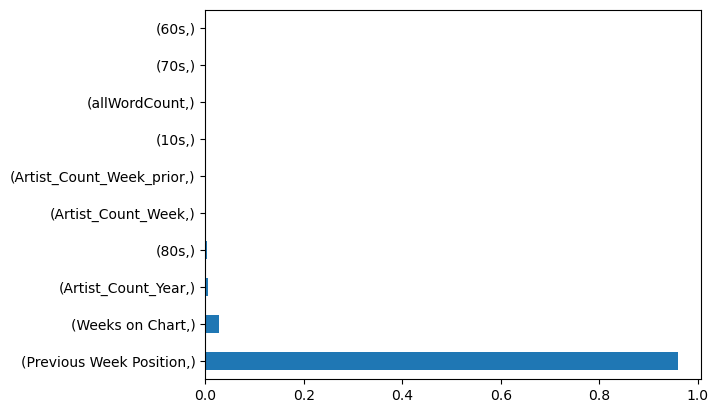

In [85]:
feature_names = [X_train.columns[0:]]
importances = rf_reg.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.nlargest(10).plot(kind='barh')

The top features are Previous Week Position, Weeks on Chart, Artist Count Year, 80s Decade, and Artist Count Week.

#### What are the feature importances for the default random forest?

<AxesSubplot:>

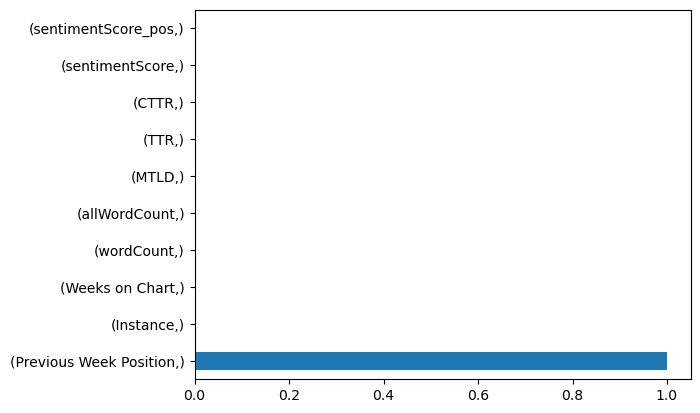

In [88]:
feature_names = [X_train.columns[0:]]
importances = rf_reg_default.feature_importances_

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.nlargest(10).plot(kind='barh')

The largest, and almost only, important feature for the default Random Forest model is Previous Week Position.
#### It appears that Previous Week Position is most important in the Random Forest models.

### We noticed in both LGBM and Random Forest that uncontrolable factors are coming in as most influential. What if we only want to explore controlable factors? 
### LGBM is more efficient and produced higher accuracy in our previous model exploration. We will conduct our "Controllable" analysis with LGBM only.

# Test LGBM with controllable factors only

#### Adjust the training and testing data to include controllable factors only.

In [89]:
X_train_c = X_train.drop(columns = {'Previous Week Position', 'Instance', 'Weeks on Chart', 'Artist_Count_Total', 'Artist_Count_Year', 'Artist_Count_Year_prior', 'Artist_Count_Week', 'Artist_Count_Week_prior', '00s', '10s', '20s', '50s', '60s', '70s', '80s', '90s'})
X_test_c = X_test.drop(columns = {'Previous Week Position', 'Instance', 'Weeks on Chart', 'Artist_Count_Total', 'Artist_Count_Year', 'Artist_Count_Year_prior', 'Artist_Count_Week', 'Artist_Count_Week_prior', '00s', '10s', '20s', '50s', '60s', '70s', '80s', '90s'})
X_train_c.columns

Index(['wordCount', 'allWordCount', 'MTLD', 'TTR', 'CTTR', 'sentimentScore',
       'sentimentScore_pos', 'sentimentScore_neg', 'emoWordCount', 'emo_score',
       'joy_normalized_ind', 'sadness_normalized_ind', 'anger_normalized_ind',
       'disgust_normalized_ind', 'trust_normalized_ind',
       'anticipation_normalized_ind', 'fear_normalized_ind',
       'surprise_normalized_ind', 'happy_normalized_ind',
       'sorrow_normalized_ind'],
      dtype='object')

## LGBM with Controllable Factors

#### Random Search for HyperParameters

In [93]:
param_grid = {'num_leaves' : np.arange(15, 2000, 1), 'max_depth' : np.arange(2, 20,1), 'learning_rate' : np.arange(.75, 1.25, .01), 'n_estimators' : np.arange(75, 175, 1)}
start_time = datetime.now()
lgbm_rs = LGBMRegressor()
lgbm_cv = RandomizedSearchCV(lgbm_rs, param_grid, n_iter = 50, cv=5, random_state = 123)
lgbm_cv.fit(X_train_c, y_train)
end_time = datetime.now()

print("Best Score:" + str(lgbm_cv.best_score_))
print("Best Parameter: " + str(lgbm_cv.best_params_))
print(end_time - start_time)

Best Score:0.36932320543217845
Best Parameter: {'num_leaves': 666, 'n_estimators': 88, 'max_depth': 16, 'learning_rate': 0.77}
0:07:33.278409


From the random search: The best score is .369 with 666 leaves, 88 estimators, depth of 16 and .77 learning_rate. It took 7 minutes and 33 seconds to run.

#### Run a final, controllable Light Gradient Boosting Machine with ... leaves, ... estimators, depth of ..., and .... learning_rate.  

In [148]:
start_time = datetime.now()
lgbm_controlable = LGBMRegressor(num_leaves = 666, n_estimators = 88, max_depth = 16, learning_rate = .77)
lgbm_controlable.fit(X_train_c, y_train)
end_time = datetime.now()

print("Train Score: " + str(lgbm_controlable.score(X_train_c, np.ravel(y_train))))
print("Test Score: " + str(lgbm_controlable.score(X_test_c, np.ravel(y_test))))
print(end_time - start_time)

Train Score: 0.4712831730895075
Test Score: 0.3819539319395123
0:00:03.141642


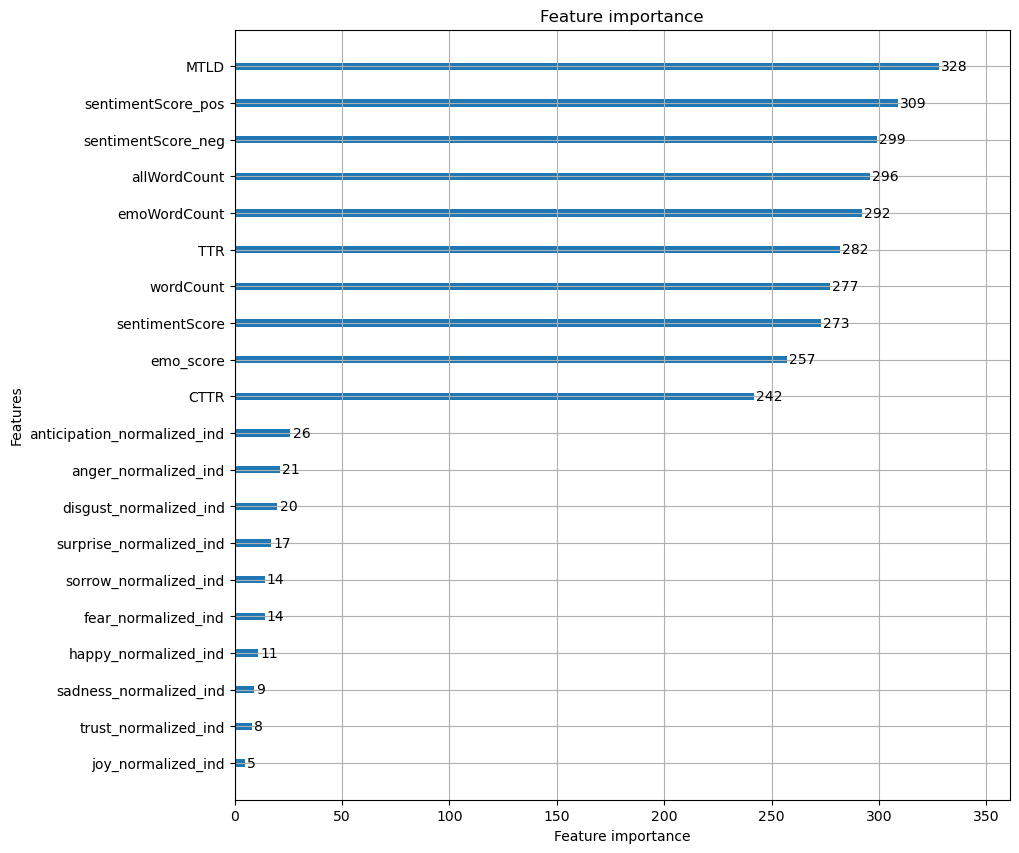

In [149]:
ax = lightgbm.plot_importance(lgbm, max_num_features=40, figsize=(10,10))
plt.show()

### Metrics for LGBM Models

#### LGBM All Factors

In [150]:
y_test_pred = lgbm_final.predict(X_test)
MAE = (abs(np.ravel(y_test) - y_test_pred)).mean()
MSE = ((np.ravel(y_test) - y_test_pred)**2).mean()
RMSE = np.sqrt(MSE)
VAR = ((np.ravel(y_test) - np.mean(np.ravel(y_test)))**2).mean()
R = (1 - (MSE/VAR))
print('MAE:', round(MAE,4), 
      'MSE:', round(MSE,4), 
      'RMSE:', round(RMSE,4), 
      'R_Sqr:', round(R,4))

MAE: 5.8958 MSE: 79.4554 RMSE: 8.9138 R_Sqr: 0.9044


#### LGBM Controllable Factors Only

In [151]:
y_test_pred = lgbm_controlable.predict(X_test_c)
MAE = (abs(np.ravel(y_test) - y_test_pred)).mean()
MSE = ((np.ravel(y_test) - y_test_pred)**2).mean()
RMSE = np.sqrt(MSE)
VAR = ((np.ravel(y_test) - np.mean(np.ravel(y_test)))**2).mean()
R = (1 - (MSE/VAR))
print('MAE:', round(MAE,4), 
      'MSE:', round(MSE,4), 
      'RMSE:', round(RMSE,4), 
      'R_Sqr:', round(R,4))

MAE: 17.9598 MSE: 513.9297 RMSE: 22.67 R_Sqr: 0.382


Notice, our model performance is not as impressive when only including controllable factors. As the full dataset (R^2 of .904 compared to R^2 of .382). 
Regardless, we see that our model does offer some insight to factors with higher predictability, which is our main quesiton of interest.
Our top controllable factors according to our LGBM model are MTLD, sentimentScore, WordCount, TTR, emo_score, and CTTR.

### Explore relationship between controllable factors and song ranking

In [173]:
check = df.groupby(['Week Position'])['MTLD'].mean()
print("Average MTLD for top 5 songs is: " + str(round(np.mean(check.head()), 2)))
print("Average MTLD for bottom 5 songs is: " + str(round(np.mean(check.tail()), 2)))

check = df.groupby(['Week Position'])['sentimentScore_pos'].mean()
print("Average Positive Sentiment Score for top 5 songs is: " + str(round(np.mean(check.head()), 2)))
print("Average Positive Sentiment Score for bottom 5 songs is: " + str(round(np.mean(check.tail()), 2)))

check = df.groupby(['Week Position'])['sentimentScore_neg'].mean()
print("Average Negative Sentiment Score for top 5 songs is: " + str(round(np.mean(check.head()), 4)))
print("Average Negative Sentiment Score for bottom 5 songs is: " + str(round(np.mean(check.tail()), 4)))

check = df.groupby(['Week Position'])['allWordCount'].mean()
print("Average Total Work Count for top 5 songs is: " + str(round(np.mean(check.head()), 2)))
print("Average Total Work Count MTLD for bottom 5 songs is: " + str(round(np.mean(check.tail()), 2)))

check = df.groupby(['Week Position'])['TTR'].mean()
print("Average TTR for top 5 songs is: " + str(round(np.mean(check.head()), 2)))
print("Average TTR for bottom 5 songs is: " + str(round(np.mean(check.tail()), 2)))

Average MTLD for top 5 songs is: 32.93
Average MTLD for bottom 5 songs is: 35.95
Average Positive Sentiment Score for top 5 songs is: 0.17
Average Positive Sentiment Score for bottom 5 songs is: 0.16
Average Negative Sentiment Score for top 5 songs is: 0.0785
Average Negative Sentiment Score for bottom 5 songs is: 0.0789
Average Total Work Count for top 5 songs is: 189.21
Average Total Work Count MTLD for bottom 5 songs is: 166.07
Average TTR for top 5 songs is: 0.32
Average TTR for bottom 5 songs is: 0.35


# Summary

In our final modeling phase, we explore the Light Gradient Boosting Machine (LGBM) as well as the Random Forest (RF) algorithm. We utilize random search 5-fold cross validation to find hyper-parameter values.
The random search process takes about 1 hour for LGBM and 10+ hours for RF.

LGBM is not only more efficient, it also produces a higher goodness of fit.
    LGBM - training R^2 of .907 and test of .904
    RF - traning R^2 of .889 and test of .889

Utilizing LGBM, we conduct a similar random search 5-fold cross validation with controllable factors only. Our R^2 value significantly decreases to .38 for training and .304 for testing.

We gain a better insight to controllable factors that relate to a song's weekly position on the Billboard Top 100 chart. Namely, MTLD, sentimentScore, WordCount, TTR, emo_score, and CTTR.

# Our Recommendation:
## Focus on: 
### MTLD - lower performs better
### Sentiment Score - positive performs better, negative performs worse
### Word Count - more words performs better
### TTR - lower ratios perform better

In [174]:
# Last Update: 2023-03-15